第一步是将日期 - 时间信息合并成一个日期 - 时间，以便我们可以将它用作Pandas的一个索引。

快速检查显示前24小时pm2.5的NA值。因此，我们将需要删除第一行数据。数据集中后面还有一些零散的“NA”值。我们现在可以用0值来标记它们。

下面的脚本加载原始数据集，并将日期 - 时间信息解析为Pandas DataFrame索引。“否”列被删除，然后为每列指定更清晰的名称。最后，将NA值替换为“0”值，并且将前24小时移除。

“No”列被删除，然后为每列指定更清晰的名称。最后，将NA值替换为“0”值，并且将最初的24小时移除。

In [3]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
# 加载数据
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw_data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# 手动更改列名
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# 把所有NA值用0替换
dataset['pollution'].fillna(0, inplace=True)
# 丢弃前24小时
dataset = dataset[24:] 
# 输出前五行
print(dataset.head(5))
# 保存到文件中
dataset.to_csv('pollution.csv')
 

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


现在我们有了一个易于使用的数据形式，我们可以快速绘制每个系列的图，看看我们有什么。

下面的代码加载新的“ pollution.csv ”文件，并将每个序列作为一个单独的子图绘制，除了风速dir（这是绝对的）之外

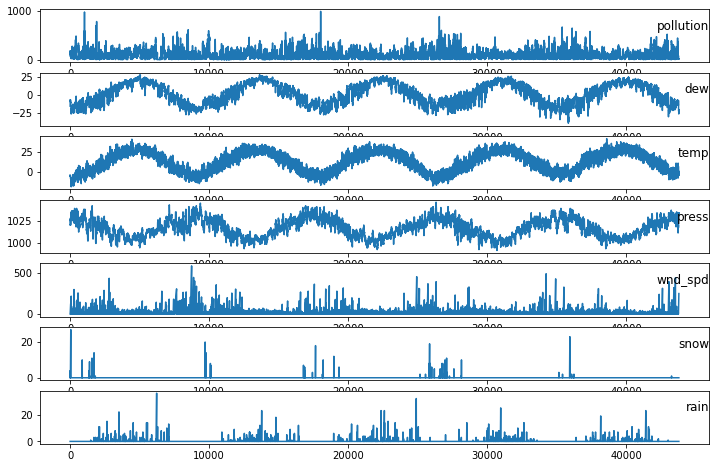

In [5]:
from pandas import read_csv
from matplotlib import pyplot
# 加载数据集
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# 指定要绘制的列
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# 绘制每一列
pyplot.figure(figsize=(12,8))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

LSTM数据准备
第一步是准备LSTM的污染数据集。

这涉及将数据集构造为监督学习问题并对输入变量进行归一化。

我们将监督学习问题的框架，作为污染测量和天气条件在前一个时间步骤（t）预测污染。

这个表述很简单，只是为了演示。您可以探索的一些替代配方包括：

根据过去24小时内的天气情况和污染情况，预测下一小时的污染情况。
预测如上所述的下一小时的污染，并给出下一小时的“预期”天气条件。
使用博客文章中开发的series_to_supervised（）函数来转换数据集：

In [11]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

# 将序列转换成监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# 加载数据集
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# 整数编码方向
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 确保所有数据是浮动的
values = values.astype('float32')
# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 构建成监督学习问题
reframed = series_to_supervised(scaled, 1, 1)
# 丢弃我们不想预测的列
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t

首先，我们必须将准备好的数据集分解为训练集和测试集。为了加速演示中对模型的训练，我们将只适合第一年的数据模型，然后在剩下的4年数据上进行评估。如果有时间的话，可以考虑探索这个测试工具的倒置版本。

下面的例子将数据集分解为训练集和测试集，然后将训练集和测试集分解为输入和输出变量。最后，输入（X）重塑成LSTM预期的3D格式，即[样例，时间步，特征]。

In [12]:
# 把数据分为训练集和测试集
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# # 把输入重塑成3D格式 [样例， 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


##  前面8个特征，预测下一行的第一个值

In [18]:
from tensorflow.keras.models import Sequential
from keras.layer import LSTM,Dense
# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 拟合网络
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# 绘制历史数据
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

ModuleNotFoundError: No module named 'google'

评估模型
模型拟合后，我们可以预测整个测试数据集。

我们将预测与测试数据集结合起来，并将缩放比例倒置。我们还将测试数据集与预期的污染数据进行了转换。

通过预测值和实际值，我们可以计算模型的误差分数。在这种情况下，我们计算出与变量本身相同的单位给出误差的均方根误差（RMSE）。

In [16]:
# 作出预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# 反向缩放预测值
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反向缩放实际值
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)1

array([0.14889336, 0.15995975, 0.18209255, 0.13883299, 0.10965794,
       0.1056338 , 0.12474848, 0.12072434, 0.13279678, 0.14084506],
      dtype=float32)